# RSE-D-24-02041

This notebook contains an example for training a random forest (RF) regression model to predict the spectral invariant parameters from top-of-canopy (TOC) reflectance hyperspectral images. The method was introduced by [Ihalainen et al. (2024).](http://ssrn.com/abstract=4903267) The code below does not require you to install the `spectralinvariant` package; all you need are the libraries imported in the cell below


In [1]:
%matplotlib widget

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
from sklearn.ensemble import RandomForestRegressor
from skimage.exposure import adjust_gamma # Used only for visualization.
from spectral import envi # Used for loading hyperspectral data stored in the ENVI image format.


Define functions generating synthetic data to train a RF model and for performing the illumination correction from the spectral invariants predicted by the RF. We use `numba` to speed up computing the illumination-corrected image.

In [2]:
@njit(parallel=True, fastmath=True)
def illumination_correction_numba(hypdata, ydata, dirglob, albedo, output):
    """Apply the illumination correction to the hyperspectral data using Numba to speed up the computation.

    You can also define `output` as a new array with the same shape as `hypdata` instead of passing it as an argument. However, that approach tends to be slower.
    Args:
        hypdata (np.ndarray): The hyperspectral data. Shape (npix, nbands).
        ydata (np.ndarray): The parameters of the model. Shape (npix, 5).
        dirglob (np.ndarray): The direct global irradiance. Shape (nbands,).
        albedo (np.ndarray): The albedo. Shape (nbands,).
        output (np.ndarray): The output array. Shape (npix, nbands).
    Returns:
        np.ndarray: The illumination-corrected hyperspectral data.
    """
    npix, nbands = hypdata.shape
    for idx in prange(npix):
            y = ydata[idx]
            beta_d = y[1]
            for bnd in prange(nbands):
                drg = dirglob[bnd]
                alb = albedo[bnd]
                k = beta_d + (y[0] - beta_d) * drg + (y[2] * alb + y[4]) / (1. - y[3] * alb)
                output[idx, bnd] = hypdata[idx, bnd] / k
            
    return output


def find_nearest(array, value):
    """Find the index of the nearest value in an array.
    Used for finding the index of the nearest wavelength in the spectral data.
    Args:
        array (np.ndarray): The array.
        value (float): The value.
    Returns:
        int: The index of the nearest value.
    """
    return abs(array - value).argmin()


def forward_model(reflectance, dirglob, albedo, ydata):
    """Compute the hyperspectral data from the spectral invariants.
    Used for generating synthetic data.
    
    Args:
        reflectance (np.ndarray): The reflectance. Shape (npix,).
        dirglob (np.ndarray): The direct global irradiance. Shape (nbands,).
        albedo (np.ndarray): The albedo. Shape (nbands,).
        ydata (np.ndarray): The parameters of the model. Shape (npix, 5).
    Returns:
        np.ndarray: The hyperspectral data. Shape (npix, nbands).
    """

    k_sky = ydata[:,1] + (ydata[:,0] - ydata[:,1])*dirglob[:,None]
    k_can = (ydata[:,2]*albedo[:,None] + ydata[:,4]) / (1. - ydata[:,3]*albedo[:,None])
    return reflectance[:,None] * (k_sky + k_can)

Load the spectra used in training random forest. The spectral bands match the bands measured by the Specim IQ hyperspectral camera. However, the bands have been resampled to the closest integer wavelength value.

In [3]:
fpath_data = Path(f"../data/data_RSE_D_24_02041")

# The specim IQ spectral bands
wls_iq = np.loadtxt(fpath_data / "wavelengths_specim_iq.txt")

# Direct-to-global irradiance ratio for the CKA cite
dirglob_data = np.loadtxt(fpath_data / "dirglob.csv") 
wls = dirglob_data[:, 0] # The resampled specim IQ spectral bands
dirglob = dirglob_data[:, 1]

# Reference leaf albedo
reference_albedo = np.loadtxt(fpath_data / "reference_albedo.csv")[:, 1]

# Load the spectral library. The leaf spectra were taken from the measurement data by Hovi & Rautiainen (2022): https://data.mendeley.com/datasets/nvgjcn5nsx/1
reflectances = np.loadtxt(fpath_data / "spectral_library.csv")[:, 1:].T  # The first column is the wavelength, which we ignore since it's the same as `wls`

# Load the spectral invariants 
ydata = np.loadtxt(fpath_data / "spectral_invariants.csv")

Generate the synthetic data used in training the random forest model.

In [4]:
np.random.seed(0)

# Generate synthetic data, i.e., TOC reflectance spectra (xdata) and the corresponding spectral invariants (ydata)
sigma_hsi = 0.001
sigma = [0.05, 0.05, 0.02, 0.02, 0.005]
n_samples = 30

Y_train = []
X_train = []
for reflectance in reflectances:
    for y in ydata:
        y_sampled = np.array([np.random.normal(y[i], sigma[i], n_samples) for i in range(5)]).T
        y_sampled[:, 1] = 1 - abs(1 - y_sampled[:,1]) # Ensure that beta_D is in [0, 1]
        y_sampled[:, :4] = abs(y_sampled[:, :4]) # Ensure that beta_0, beta_D, rho, and p are positive

        x_sampled = forward_model(reflectance, dirglob, reference_albedo, y_sampled).T
        x_sampled = abs(x_sampled + np.random.normal(0, sigma_hsi, x_sampled.shape)) # Add noise to the hyperspectral data and ensure that it's positive

        Y_train.append(y_sampled)
        X_train.append(x_sampled)


X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)


Select a subset of empirically determined bands (`wls_subset`) for the synthetic TOC reflectances (`x_train`) and shuffle the synthetic data:

In [5]:
wls_subset = [430, 450, 480, 550, 650, 680, 700, 718, 770, 790]
bands = [find_nearest(wls, wl_) for wl_ in wls_subset]
x_train = X_train[:, bands]

# Randomly shuffle the data
ndata = x_train.shape[0]
indices = np.random.randint(0, ndata, size=ndata)
x_train = x_train[indices]
y_train = Y_train[indices]

x_train.shape, y_train.shape

((237300, 10), (237300, 5))

Train the random forest model:

In [6]:
rf = RandomForestRegressor(random_state=123, bootstrap=True, oob_score=True, n_jobs=-1,
                           n_estimators=110, criterion="squared_error", max_features="sqrt",
                           max_depth=26, min_samples_split=20, min_samples_leaf=21)

# If you want to use the (mostly) default hyperparameters, you can use the following line instead. This can yield better results but at the risk of overfitting.
# rf = RandomForestRegressor(random_state=123, bootstrap=True, oob_score=True, n_jobs=-1, criterion="squared_error", max_features="sqrt")

rf.fit(x_train, y_train)

# Optional: you can save the model using joblib if you want to use it later.
# from joblib import dump
# dump(rf, "rf.joblib")

# Load the model using joblib
# from joblib import load
# rf = load("rf.joblib")

RandomForestRegressor(max_depth=26, max_features='sqrt', min_samples_leaf=21,
                      min_samples_split=20, n_estimators=110, n_jobs=-1,
                      oob_score=True, random_state=123)

Apply the illumination correction method on hyperspectral data:

In [7]:
# Load the hyperspectral image
fpath_hsi = Path(r"path_to_hyperspectral_image")
fname_hsi = fpath_hsi / "filename.hdr"

img = envi.open(fname_hsi)
image = img.open_memmap()# * 0.0001 # The TOC reflectance data is assumed to be stored in 16-bit unsigned integers, so we need to scale it to [0, 1].
nrows, ncols, nbands = image.shape

# Resample the bands
xdata = image.reshape(-1, nbands)
interp_func = lambda y: np.interp(wls, wls_iq, y)
xdata = np.apply_along_axis(func1d=interp_func, axis=1, arr=xdata) # This will take a while...
image = xdata.reshape(nrows, ncols, -1)


In [8]:
y_pred = rf.predict(xdata[:, bands])
y_img = y_pred.reshape((nrows, ncols, 5))

xdata_ic = illumination_correction_numba(xdata, y_pred, dirglob, reference_albedo, np.zeros((y_pred.shape[0], dirglob.shape[0])))
image_ic = np.reshape(xdata_ic, (image.shape))

Visualize the result:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

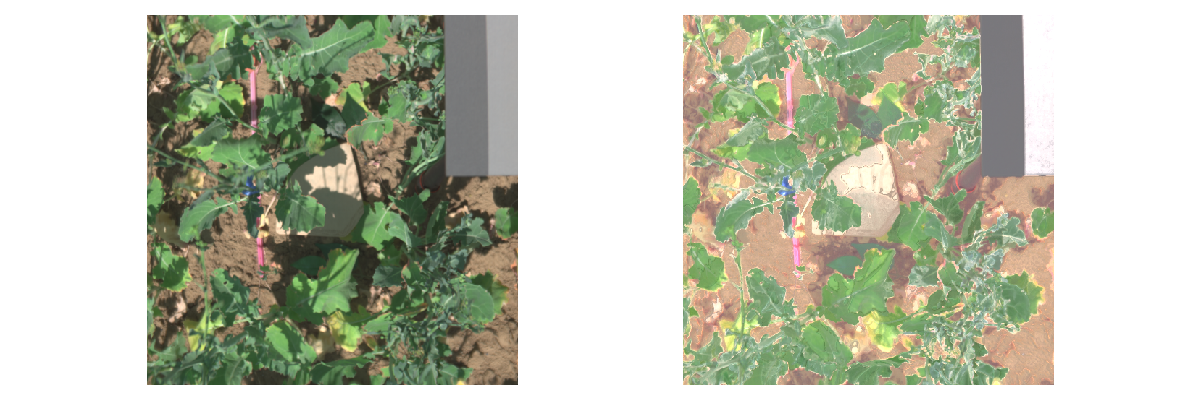

In [9]:
rgb_bands = [find_nearest(wls, wl_) for wl_ in [650, 550, 480]]
rgb = adjust_gamma(image[..., rgb_bands], gamma=0.5, gain=1.5)
rgb_ic = adjust_gamma(image_ic[..., rgb_bands], gamma=0.5, gain=1.5)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True, sharex=True, sharey=True)
axs[0].matshow(rgb)
axs[0].axis("off")
axs[1].matshow(rgb_ic)
axs[1].axis("off")
plt.show()